# Showcases Integrated Gradients and DeepLifton CIFAR10 dataset

This tutorial demonstrates how to apply model interpretability algorithms from Captum library on a simple model and test samples from CIFAR dataset.

In this tutorial we build a simple model as described in:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Then we use attribution algorithms such as `IntegratedGradients` and `DeepLift` to attribute the label of the image to the input pixels and visualize it.

In [16]:
!pip install -q captum

In [17]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import visualization as viz

In the cell below we load test and train datasets, define image transformers and supported classification label classes.

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=3,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


We define a classification network

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Trains `Net` model for a very small number of epochs. The training code snippet is copied from the tutorial mentioned above.
In order to avoid training the model every time from scratch, we save a pretrained version of the model in `models` folder and load it from there. https://github.com/pytorch/captum/blob/master/tutorials/models/cifar_torchvision.pt

In [21]:
import os

# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Download the model file
!wget -O models/cifar_torchvision.pt https://github.com/pytorch/captum/raw/master/tutorials/models/cifar_torchvision.pt


--2025-02-12 15:38:39--  https://github.com/pytorch/captum/raw/master/tutorials/models/cifar_torchvision.pt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pytorch/captum/master/tutorials/models/cifar_torchvision.pt [following]
--2025-02-12 15:38:39--  https://raw.githubusercontent.com/pytorch/captum/master/tutorials/models/cifar_torchvision.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249703 (244K) [application/octet-stream]
Saving to: ‘models/cifar_torchvision.pt’

models/cifar_torchv 100%[===================>] 243.85K  --.-KB/s    in 0.08s   

2025-02-12 15:38:39 (3.14 MB/s) - ‘models/c

In [22]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('models/cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), 'models/cifar_torchvision.pt')

Using existing trained model


<ipython-input-22-dc5c9e7939d5>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('models/cifar_torchvision.pt'))


In the cell below we load some images from the test dataset and perform predictions.

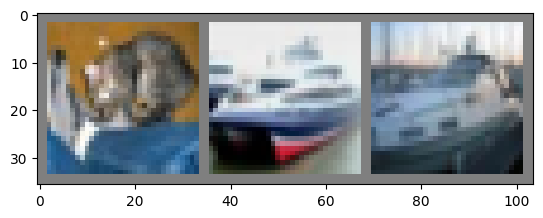

GroundTruth:    cat  ship  ship
Predicted:    cat  ship  ship


In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(3)))


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(3)))

Let's choose a test image at index `ind` and apply some of our attribution algorithms on it.

In [26]:
ind = 1

input = images[ind].unsqueeze(0)
input.requires_grad = True

Sets model to eval mode for interpretation purposes

In [27]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

A generic function that will be used for calling `attribute` on attribution algorithm defined in input.

In [28]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )

    return tensor_attributions


Applies integrated gradients attribution algorithm on test image. Integrated Gradients computes the integral of the gradients of the output prediction for the class index `ind` with respect to the input image pixels. More details about integrated gradients can be found in the original paper: https://arxiv.org/abs/1703.01365

In [29]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0263], dtype=torch.float64)


Applies DeepLift on test image. Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.

In [30]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In the cell below we will visualize the attributions for `Saliency Maps`, `DeepLift` and `Integrated Gradients`.

Original Image
Predicted: ship  Probability: 0.6684957146644592


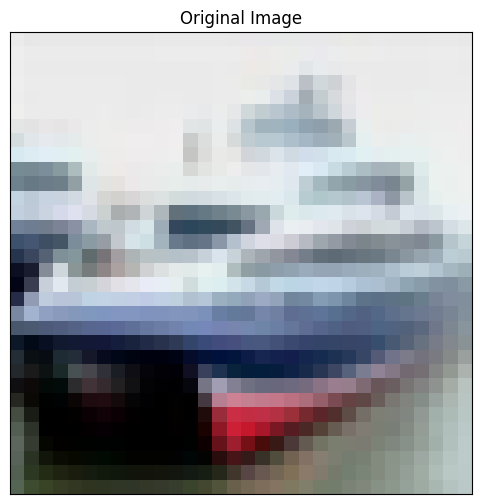

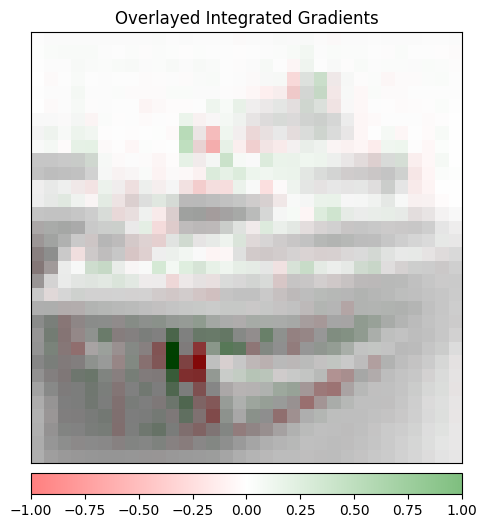

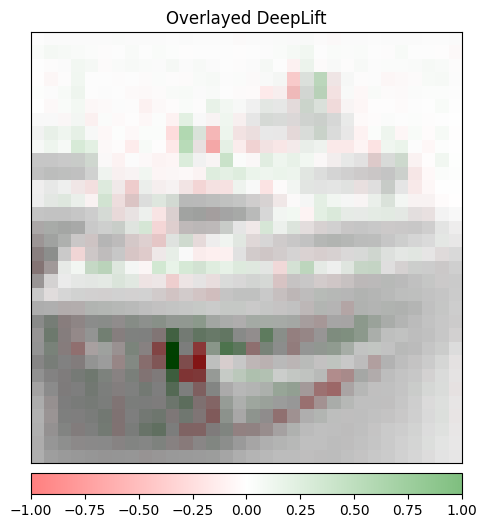

In [31]:
print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")



**Integrated Gradients vs. DeepLift:**

* IG works by approximating feature importance through interpolations between a baseline (e.g., a black image) and the original input.
* DeepLift assigns attributions based on changes from a reference point, often making it more sensitive to local variations.
* If IG and DeepLift give similar results, it suggests the model is consistently recognizing important features in the image.